# 🔬 Training Vision Transformer cho Segmentation

Notebook này thực hiện training model **Vision Transformer thuần** cho bài toán phân đoạn khối u da:

## 🎯 Model: Pure Vision Transformer Segmentation
- **Architecture**: Vision Transformer thuần + Simple MLP Segmentation Head
- **Backbone**: Vision Transformer Tiny (`vit_tiny_patch16_224`) từ timm
- **Parameters**: ~5M (cực kỳ nhẹ, memory efficient)
- **Ưu điểm**: 
  - ViT thuần 100% với self-attention global
  - Không có CNN components
  - Memory efficient cho GPU constraints
  - Simple và stable architecture
- **Learning Rate Scheduler**: Cosine Annealing với warmup

## 📊 Training Configuration:
- **Epochs**: 20 (với early stopping)
- **Learning Rate**: 1e-4
- **Batch Size**: 2 (optimized cho ViT memory usage)
- **Optimizer**: Adam với weight decay 1e-4
- **Loss Function**: Combined Loss (BCE + Dice)
- **Metrics**: Dice Coefficient, Jaccard Index (IoU)
- **Scheduler**: Cosine Annealing với warmup (5 epochs)
- **Mixed Precision**: FP16 để tiết kiệm memory

## 1. Import thư viện và setup

In [10]:
# # Cài đặt các thư viện cần thiết
# !pip install segmentation-models-pytorch timm torch torchvision
# !pip install transformers einops
# !pip install albumentations opencv-python-headless
# !pip install matplotlib seaborn scikit-learn pillow tqdm

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation models
import segmentation_models_pytorch as smp

# Timm for ViT backbone
import timm

# Transformers for ViT
from transformers import ViTModel, ViTConfig

# Einops for tensor operations
import einops

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.metrics import jaccard_score, f1_score

# AGGRESSIVE GPU optimization for ViT
print("🔥 AGGRESSIVE GPU Memory Optimization...")

# Kill all GPU processes first
torch.cuda.empty_cache()
import gc
for i in range(5):
    gc.collect()
    torch.cuda.empty_cache()

# Set very conservative memory fraction
torch.cuda.set_per_process_memory_fraction(0.4)  # Only use 40% of GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} (with EXTREME memory optimization)")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"Total GPU Memory: {total_memory:.1f} GB")
    print(f"Allowed Memory: {total_memory * 0.4:.1f} GB (40% fraction)")
    
    # Check current usage
    allocated = torch.cuda.memory_allocated() / 1024**3
    print(f"Currently allocated: {allocated:.2f} GB")
    # Clear GPU cache
    torch.cuda.empty_cache()
else:
    print("No GPU available")

# Tạo thư mục models nếu chưa có
os.makedirs('models', exist_ok=True)
print("✅ Setup hoàn tất!")

🔥 AGGRESSIVE GPU Memory Optimization...
Using device: cuda (with EXTREME memory optimization)
GPU: NVIDIA GeForce RTX 5070 Ti
Total GPU Memory: 15.5 GB
Allowed Memory: 6.2 GB (40% fraction)
Currently allocated: 0.06 GB
✅ Setup hoàn tất!


## 2. Dataset và Data Augmentation

In [12]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_size = target_size
        
        # Lấy danh sách file images
        self.image_files = sorted([f for f in os.listdir(images_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        print(f"Found {len(self.image_files)} images in {images_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_mask.png",
            f"{base_name}.png"
        ]
        
        mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.masks_dir, mask_name)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                break
        
        if mask is None:
            # Create dummy mask if not found
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Dataset class và augmentations đã được định nghĩa!")

✅ Dataset class và augmentations đã được định nghĩa!


In [13]:
# Create datasets
train_dataset = ISICDataset(
    images_dir='data/train/images',
    masks_dir='data/train/ground_truth',
    transform=train_transform,
    target_size=(512, 512)
)

val_dataset = ISICDataset(
    images_dir='data/val/images',
    masks_dir='data/val/ground_truth',
    transform=val_transform,
    target_size=(512, 512)
)

# Create data loaders (EXTREME memory optimization)
batch_size = 1  # MINIMUM batch size for ViT
accumulation_steps = 8  # Simulate batch_size=8 with gradient accumulation
print(f"🔧 Effective batch size: {batch_size * accumulation_steps} (via gradient accumulation)")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"📊 Dataset Summary:")
print(f"   - Training samples: {len(train_dataset)}")
print(f"   - Validation samples: {len(val_dataset)}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training batches: {len(train_loader)}")
print(f"   - Validation batches: {len(val_loader)}")

Found 2594 images in data/train/images
Found 100 images in data/val/images
🔧 Effective batch size: 8 (via gradient accumulation)
📊 Dataset Summary:
   - Training samples: 2594
   - Validation samples: 100
   - Batch size: 1
   - Training batches: 2594
   - Validation batches: 100


## 3. U-Net ViT Model Definition

In [14]:
class ViTSegmentation(nn.Module):
    def __init__(self, vit_model_name="vit_small_patch16_224", num_classes=1, pretrained=True):
        super().__init__()
        
        # Load Vision Transformer từ timm (classification head)
        self.vit = timm.create_model(
            vit_model_name, 
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Get feature dimension
        self.feature_dim = self.vit.num_features
        
        # Simple segmentation head
        self.seg_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 14 * 14 * num_classes)  # 14x14 patches for 224x224 input
        )
        
        self.num_classes = num_classes
        
        print(f"✅ ViT Segmentation loaded: {vit_model_name}")
        print(f"   - Feature dimension: {self.feature_dim}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
    
    def forward(self, x):
        # Resize input cho ViT (224x224)
        original_size = x.shape[-2:]
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Extract global features từ ViT
        features = self.vit(x_resized)  # [batch, feature_dim]
        
        # Generate segmentation map
        seg_output = self.seg_head(features)  # [batch, 14*14*num_classes]
        
        # Reshape to spatial format
        batch_size = seg_output.shape[0]
        seg_map = seg_output.view(batch_size, self.num_classes, 14, 14)
        
        # Upsample về original input size
        seg_map = F.interpolate(seg_map, size=original_size, mode='bilinear', align_corners=False)
        
        # Return logits (no sigmoid) for BCEWithLogitsLoss
        return seg_map

# CRITICAL: Clear ALL GPU memory và kill other processes
print("🧹 Clearing ALL GPU memory...")

# Clear PyTorch cache
torch.cuda.empty_cache()
import gc
gc.collect()

# Force garbage collection multiple times
for i in range(3):
    gc.collect()
    torch.cuda.empty_cache()

print("\n⚠️  CRITICAL: Nếu vẫn OOM, hãy RESTART KERNEL trước!")
print("   1. Kernel -> Restart & Clear Output")
print("   2. Chạy lại từ đầu với GPU optimizations")
print("   3. Hoặc uncomment dòng: device = torch.device('cpu')")

# EMERGENCY: Uncomment this line if still OOM
# device = torch.device('cpu')
# print("🚨 EMERGENCY: Switched to CPU training!")

# Initialize model (ViT segmentation - using TINY for extreme memory efficiency)
print("🔬 Initializing ViT Segmentation model...")
model = ViTSegmentation(
    vit_model_name="vit_tiny_patch16_224",  # TINY ViT - only ~5M parameters
    num_classes=1,
    pretrained=True
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model size: ~{total_params/1e6:.1f}M parameters")

🧹 Clearing ALL GPU memory...



⚠️  CRITICAL: Nếu vẫn OOM, hãy RESTART KERNEL trước!
   1. Kernel -> Restart & Clear Output
   2. Chạy lại từ đầu với GPU optimizations
   3. Hoặc uncomment dòng: device = torch.device('cpu')
🔬 Initializing ViT Segmentation model...
✅ ViT Segmentation loaded: vit_tiny_patch16_224
   - Feature dimension: 192
   - Pre-trained: True
   - Number of classes: 1
📊 Model Statistics:
   - Total parameters: 5,804,932
   - Trainable parameters: 5,804,932
   - Model size: ~5.8M parameters


## 4. Loss Functions và Metrics

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()  # Safe for autocast
        self.dice = DiceLoss()
        
    def forward(self, logits, target):
        # logits: raw output from model (before sigmoid)
        # target: ground truth masks
        
        # Ensure logits and target have the same shape
        if logits.dim() == 4 and target.dim() == 3:
            logits = logits.squeeze(1)  # Remove channel dimension: [batch, H, W]
        elif logits.dim() == 3 and target.dim() == 4:
            target = target.squeeze(1)  # Remove channel dimension: [batch, H, W]
        
        # BCE with logits (safe for autocast)
        bce_loss = self.bce(logits, target)
        
        # Dice loss needs probabilities, so apply sigmoid
        pred_probs = torch.sigmoid(logits)
        dice_loss = self.dice(pred_probs, target)
        
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

def calculate_dice_batch(logits, target, threshold=0.5):
    """Calculate Dice coefficient for a batch (logits input)"""
    # Convert logits to probabilities
    pred = torch.sigmoid(logits)
    
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-6)
    
    return dice.item()

def calculate_jaccard_batch(logits, target, threshold=0.5):
    """Calculate Jaccard Index (IoU) for a batch (logits input)"""
    # Convert logits to probabilities
    pred = torch.sigmoid(logits)
    
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    # Convert to boolean for intersection and union
    pred_bool = (pred > threshold).bool()
    target_bool = target.bool()
    
    intersection = (pred_bool & target_bool).float().sum()
    union = (pred_bool | target_bool).float().sum()
    
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

print("✅ Loss functions và metrics đã được định nghĩa!")

✅ Loss functions và metrics đã được định nghĩa!


## 5. Cosine Annealing với Warmup Scheduler

In [16]:
class CosineAnnealingWarmupRestarts(torch.optim.lr_scheduler._LRScheduler):
    """
    Cosine Annealing với Warmup scheduler
    """
    def __init__(self, optimizer, first_cycle_steps, cycle_mult=1., max_lr=0.1, min_lr=0.001, 
                 warmup_steps=0, gamma=1., last_epoch=-1):
        self.first_cycle_steps = first_cycle_steps
        self.cycle_mult = cycle_mult
        self.base_max_lr = max_lr
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.gamma = gamma
        
        self.cur_cycle_steps = first_cycle_steps
        self.cycle = 0
        self.step_in_cycle = last_epoch
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # Set learning rate to min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) * \
                    (1 + np.cos(np.pi * (self.step_in_cycle-self.warmup_steps) / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(np.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

print("✅ Cosine Annealing Warmup scheduler đã được định nghĩa!")

✅ Cosine Annealing Warmup scheduler đã được định nghĩa!


## 6. Training Function

In [17]:
def train_unet_vit(model, train_loader, val_loader, num_epochs=20, lr=1e-4, warmup_epochs=5, patience=5, min_delta=0.001):
    """
    Training function for U-Net ViT with Cosine Annealing Warmup scheduler and Early Stopping
    
    Args:
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change to qualify as an improvement
    """
    # Loss function and optimizer
    criterion = CombinedLoss(alpha=0.5)  # Combination of BCE and Dice loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Cosine Annealing với Warmup scheduler
    scheduler = CosineAnnealingWarmupRestarts(
        optimizer,
        first_cycle_steps=num_epochs,
        max_lr=lr,
        min_lr=lr*0.01,
        warmup_steps=warmup_epochs
    )
    
    # Mixed precision training for memory efficiency
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_dice': [],
        'val_dice': [],
        'train_jaccard': [],
        'val_jaccard': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False
    
    print(f"🚀 Bắt đầu training U-Net ViT...")
    print(f"📊 Configuration:")
    print(f"   - Epochs: {num_epochs}")
    print(f"   - Learning Rate: {lr}")
    print(f"   - Early Stopping: Patience={patience}, Min Delta={min_delta}")
    print(f"   - Warmup Epochs: {warmup_epochs}")
    print(f"   - Scheduler: Cosine Annealing với Warmup")
    print(f"   - Loss: Combined (BCE + Dice)")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_jaccard = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        
        # Gradient accumulation setup
        accumulation_steps = 8  # Simulate larger batch size
        optimizer.zero_grad()
        
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            # Mixed precision training with gradient accumulation
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    loss = loss / accumulation_steps  # Scale loss
                scaler.scale(loss).backward()
                
                # Update weights every accumulation_steps
                if (batch_idx + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss = loss / accumulation_steps  # Scale loss
                loss.backward()
                
                # Update weights every accumulation_steps
                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # Calculate metrics (outputs are logits now)
            with torch.no_grad():
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(outputs, masks)
                train_dice += dice
                train_jaccard += jaccard
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Dice': f'{dice:.3f}', 
                'Jaccard': f'{jaccard:.3f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_jaccard = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics (outputs are logits now)
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(outputs, masks)
                val_dice += dice
                val_jaccard += jaccard
                
                val_loss += loss.item()
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}', 
                    'Dice': f'{dice:.3f}', 
                    'Jaccard': f'{jaccard:.3f}'
                })
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_dice /= len(train_loader)
        val_dice /= len(val_loader)
        train_jaccard /= len(train_loader)
        val_jaccard /= len(val_loader)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_jaccard'].append(train_jaccard)
        history['val_jaccard'].append(val_jaccard)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        if abs(current_lr - new_lr) > 1e-8:
            print(f"  Learning rate changed: {current_lr:.6f} -> {new_lr:.6f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f}")
        print(f"  LR: {current_lr:.6f}")
        print("-" * 70)
        
        # Save best model and early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'models/unet_vit_model_best.pth')
            print(f"✅ New best validation loss: {val_loss:.4f} (patience reset)")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                early_stopped = True
                break
    
    # Training completion message
    if early_stopped:
        print(f"\n🏁 Training stopped early at epoch {epoch+1}/{num_epochs}")
    else:
        print(f"\n🏁 Training completed all {num_epochs} epochs")
    
    print(f"📊 Final best validation loss: {best_val_loss:.4f}")
    
    return history

print("✅ Training function đã được định nghĩa!")

✅ Training function đã được định nghĩa!


## 7. Bắt đầu Training

In [18]:
# Train the U-Net ViT model
print("🚀 Bắt đầu training U-Net ViT...")
print("⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)")
print()

unet_vit_history = train_unet_vit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    lr=1e-4,
    warmup_epochs=5,
    patience=5,      # Dừng sớm sau 5 epochs không cải thiện
    min_delta=0.001  # Cải thiện tối thiểu 0.001 để được tính
)

# Save final model
torch.save(model.state_dict(), 'models/unet_vit_model_final.pth')
print("\n🎉 U-Net ViT training hoàn thành!")
print("💾 Model đã được lưu:")
print("   - models/unet_vit_model_best.pth (best validation loss)")
print("   - models/unet_vit_model_final.pth (final epoch)")

🚀 Bắt đầu training U-Net ViT...
⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)

🚀 Bắt đầu training U-Net ViT...
📊 Configuration:
   - Epochs: 20
   - Learning Rate: 0.0001
   - Early Stopping: Patience=5, Min Delta=0.001
   - Warmup Epochs: 5
   - Scheduler: Cosine Annealing với Warmup
   - Loss: Combined (BCE + Dice)


Epoch 1/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 60.97it/s, Loss=0.7376, Dice=0.241, Jaccard=0.137]


  Learning rate changed: 0.000001 -> 0.000021
Epoch 1/20:
  Train Loss: 0.0889, Train Dice: 0.2825, Train Jaccard: 0.1763
  Val Loss: 0.6635, Val Dice: 0.3975, Val Jaccard: 0.2565
  LR: 0.000001
----------------------------------------------------------------------
✅ New best validation loss: 0.6635 (patience reset)


Epoch 2/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 63.02it/s, Loss=0.1926, Dice=0.810, Jaccard=0.680]


  Learning rate changed: 0.000021 -> 0.000041
Epoch 2/20:
  Train Loss: 0.0576, Train Dice: 0.5521, Train Jaccard: 0.4104
  Val Loss: 0.3040, Val Dice: 0.7376, Val Jaccard: 0.6004
  LR: 0.000021
----------------------------------------------------------------------
✅ New best validation loss: 0.3040 (patience reset)


Epoch 3/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 62.97it/s, Loss=0.1688, Dice=0.829, Jaccard=0.708]


  Learning rate changed: 0.000041 -> 0.000060
Epoch 3/20:
  Train Loss: 0.0424, Train Dice: 0.6390, Train Jaccard: 0.5022
  Val Loss: 0.2954, Val Dice: 0.7465, Val Jaccard: 0.6156
  LR: 0.000041
----------------------------------------------------------------------
✅ New best validation loss: 0.2954 (patience reset)


Epoch 4/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 62.44it/s, Loss=0.1655, Dice=0.807, Jaccard=0.676]


  Learning rate changed: 0.000060 -> 0.000080
Epoch 4/20:
  Train Loss: 0.0405, Train Dice: 0.6510, Train Jaccard: 0.5150
  Val Loss: 0.2753, Val Dice: 0.7607, Val Jaccard: 0.6316
  LR: 0.000060
----------------------------------------------------------------------
✅ New best validation loss: 0.2753 (patience reset)


Epoch 5/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 59.46it/s, Loss=0.2313, Dice=0.734, Jaccard=0.579]


  Learning rate changed: 0.000080 -> 0.000100
Epoch 5/20:
  Train Loss: 0.0368, Train Dice: 0.6947, Train Jaccard: 0.5592
  Val Loss: 0.2510, Val Dice: 0.7938, Val Jaccard: 0.6681
  LR: 0.000080
----------------------------------------------------------------------
✅ New best validation loss: 0.2510 (patience reset)


Epoch 6/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 61.01it/s, Loss=0.0959, Dice=0.890, Jaccard=0.802]


  Learning rate changed: 0.000100 -> 0.000099
Epoch 6/20:
  Train Loss: 0.0316, Train Dice: 0.7457, Train Jaccard: 0.6155
  Val Loss: 0.2140, Val Dice: 0.8238, Val Jaccard: 0.7111
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.2140 (patience reset)


Epoch 7/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 58.36it/s, Loss=0.1289, Dice=0.844, Jaccard=0.731]


  Learning rate changed: 0.000099 -> 0.000096
Epoch 7/20:
  Train Loss: 0.0281, Train Dice: 0.7766, Train Jaccard: 0.6542
  Val Loss: 0.2141, Val Dice: 0.8263, Val Jaccard: 0.7139
  LR: 0.000099
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 8/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 59.44it/s, Loss=0.1139, Dice=0.854, Jaccard=0.745]


  Learning rate changed: 0.000096 -> 0.000091
Epoch 8/20:
  Train Loss: 0.0258, Train Dice: 0.7967, Train Jaccard: 0.6803
  Val Loss: 0.2129, Val Dice: 0.8362, Val Jaccard: 0.7313
  LR: 0.000096
----------------------------------------------------------------------
✅ New best validation loss: 0.2129 (patience reset)


Epoch 9/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 63.37it/s, Loss=0.0881, Dice=0.900, Jaccard=0.818]


  Learning rate changed: 0.000091 -> 0.000084
Epoch 9/20:
  Train Loss: 0.0245, Train Dice: 0.8093, Train Jaccard: 0.6952
  Val Loss: 0.1905, Val Dice: 0.8496, Val Jaccard: 0.7495
  LR: 0.000091
----------------------------------------------------------------------
✅ New best validation loss: 0.1905 (patience reset)


Epoch 10/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 58.15it/s, Loss=0.1114, Dice=0.860, Jaccard=0.754]


  Learning rate changed: 0.000084 -> 0.000075
Epoch 10/20:
  Train Loss: 0.0233, Train Dice: 0.8162, Train Jaccard: 0.7050
  Val Loss: 0.1889, Val Dice: 0.8510, Val Jaccard: 0.7502
  LR: 0.000084
----------------------------------------------------------------------
✅ New best validation loss: 0.1889 (patience reset)


Epoch 11/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 59.61it/s, Loss=0.1548, Dice=0.806, Jaccard=0.676]


  Learning rate changed: 0.000075 -> 0.000066
Epoch 11/20:
  Train Loss: 0.0221, Train Dice: 0.8250, Train Jaccard: 0.7162
  Val Loss: 0.1827, Val Dice: 0.8537, Val Jaccard: 0.7538
  LR: 0.000075
----------------------------------------------------------------------
✅ New best validation loss: 0.1827 (patience reset)


Epoch 12/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 58.70it/s, Loss=0.1435, Dice=0.819, Jaccard=0.694]


  Learning rate changed: 0.000066 -> 0.000056
Epoch 12/20:
  Train Loss: 0.0216, Train Dice: 0.8312, Train Jaccard: 0.7246
  Val Loss: 0.1900, Val Dice: 0.8470, Val Jaccard: 0.7433
  LR: 0.000066
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 13/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 62.30it/s, Loss=0.1655, Dice=0.794, Jaccard=0.658]


  Learning rate changed: 0.000056 -> 0.000045
Epoch 13/20:
  Train Loss: 0.0210, Train Dice: 0.8352, Train Jaccard: 0.7306
  Val Loss: 0.1919, Val Dice: 0.8456, Val Jaccard: 0.7410
  LR: 0.000056
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 14/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 59.31it/s, Loss=0.1592, Dice=0.804, Jaccard=0.672]


  Learning rate changed: 0.000045 -> 0.000035
Epoch 14/20:
  Train Loss: 0.0202, Train Dice: 0.8414, Train Jaccard: 0.7384
  Val Loss: 0.1832, Val Dice: 0.8500, Val Jaccard: 0.7472
  LR: 0.000045
----------------------------------------------------------------------
⏳ No improvement. Patience: 3/5


Epoch 15/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 62.82it/s, Loss=0.0966, Dice=0.880, Jaccard=0.786]


  Learning rate changed: 0.000035 -> 0.000026
Epoch 15/20:
  Train Loss: 0.0197, Train Dice: 0.8450, Train Jaccard: 0.7446
  Val Loss: 0.1689, Val Dice: 0.8626, Val Jaccard: 0.7672
  LR: 0.000035
----------------------------------------------------------------------
✅ New best validation loss: 0.1689 (patience reset)


Epoch 16/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 57.25it/s, Loss=0.1209, Dice=0.849, Jaccard=0.738]


  Learning rate changed: 0.000026 -> 0.000017
Epoch 16/20:
  Train Loss: 0.0185, Train Dice: 0.8538, Train Jaccard: 0.7561
  Val Loss: 0.1619, Val Dice: 0.8696, Val Jaccard: 0.7768
  LR: 0.000026
----------------------------------------------------------------------
✅ New best validation loss: 0.1619 (patience reset)


Epoch 17/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 62.06it/s, Loss=0.1711, Dice=0.791, Jaccard=0.654]


  Learning rate changed: 0.000017 -> 0.000010
Epoch 17/20:
  Train Loss: 0.0183, Train Dice: 0.8550, Train Jaccard: 0.7586
  Val Loss: 0.1658, Val Dice: 0.8646, Val Jaccard: 0.7697
  LR: 0.000017
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 18/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 60.70it/s, Loss=0.1565, Dice=0.807, Jaccard=0.676]


  Learning rate changed: 0.000010 -> 0.000005
Epoch 18/20:
  Train Loss: 0.0176, Train Dice: 0.8604, Train Jaccard: 0.7655
  Val Loss: 0.1645, Val Dice: 0.8660, Val Jaccard: 0.7716
  LR: 0.000010
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 19/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 61.93it/s, Loss=0.1625, Dice=0.801, Jaccard=0.668]


  Learning rate changed: 0.000005 -> 0.000002
Epoch 19/20:
  Train Loss: 0.0175, Train Dice: 0.8630, Train Jaccard: 0.7693
  Val Loss: 0.1689, Val Dice: 0.8625, Val Jaccard: 0.7664
  LR: 0.000005
----------------------------------------------------------------------
⏳ No improvement. Patience: 3/5


Epoch 20/20 - Validation: 100%|██████████| 100/100 [00:01<00:00, 61.81it/s, Loss=0.1466, Dice=0.818, Jaccard=0.692]


  Learning rate changed: 0.000002 -> 0.000001
Epoch 20/20:
  Train Loss: 0.0174, Train Dice: 0.8626, Train Jaccard: 0.7692
  Val Loss: 0.1623, Val Dice: 0.8681, Val Jaccard: 0.7748
  LR: 0.000002
----------------------------------------------------------------------
⏳ No improvement. Patience: 4/5

🏁 Training completed all 20 epochs
📊 Final best validation loss: 0.1619

🎉 U-Net ViT training hoàn thành!
💾 Model đã được lưu:
   - models/unet_vit_model_best.pth (best validation loss)
   - models/unet_vit_model_final.pth (final epoch)


## 8. Visualization và Evaluation

📊 Hiển thị training history:


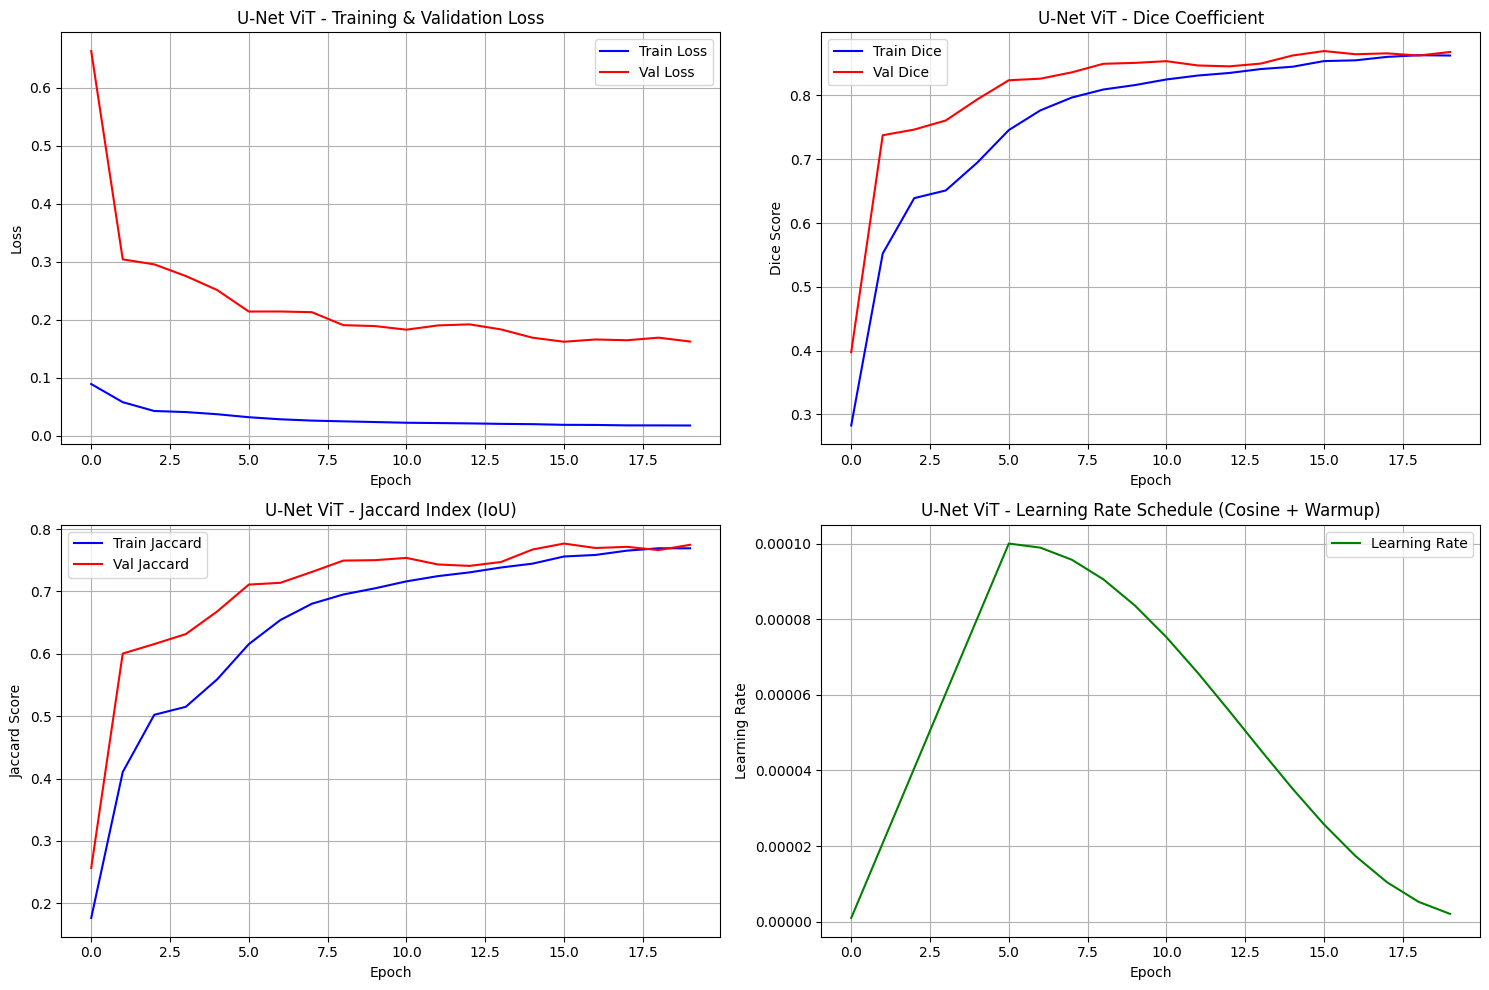

In [19]:
def plot_training_history(history, model_name="U-Net ViT"):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_losses'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_losses'], label='Val Loss', color='red')
    axes[0, 0].set_title(f'{model_name} - Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', color='blue')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', color='red')
    axes[0, 1].set_title(f'{model_name} - Dice Coefficient')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Jaccard Index
    axes[1, 0].plot(history['train_jaccard'], label='Train Jaccard', color='blue')
    axes[1, 0].plot(history['val_jaccard'], label='Val Jaccard', color='red')
    axes[1, 0].set_title(f'{model_name} - Jaccard Index (IoU)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Jaccard Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    axes[1, 1].plot(history['learning_rates'], label='Learning Rate', color='green')
    axes[1, 1].set_title(f'{model_name} - Learning Rate Schedule (Cosine + Warmup)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📊 Hiển thị training history:")
plot_training_history(unet_vit_history, "U-Net ViT")

🔍 Đánh giá model trên validation samples:


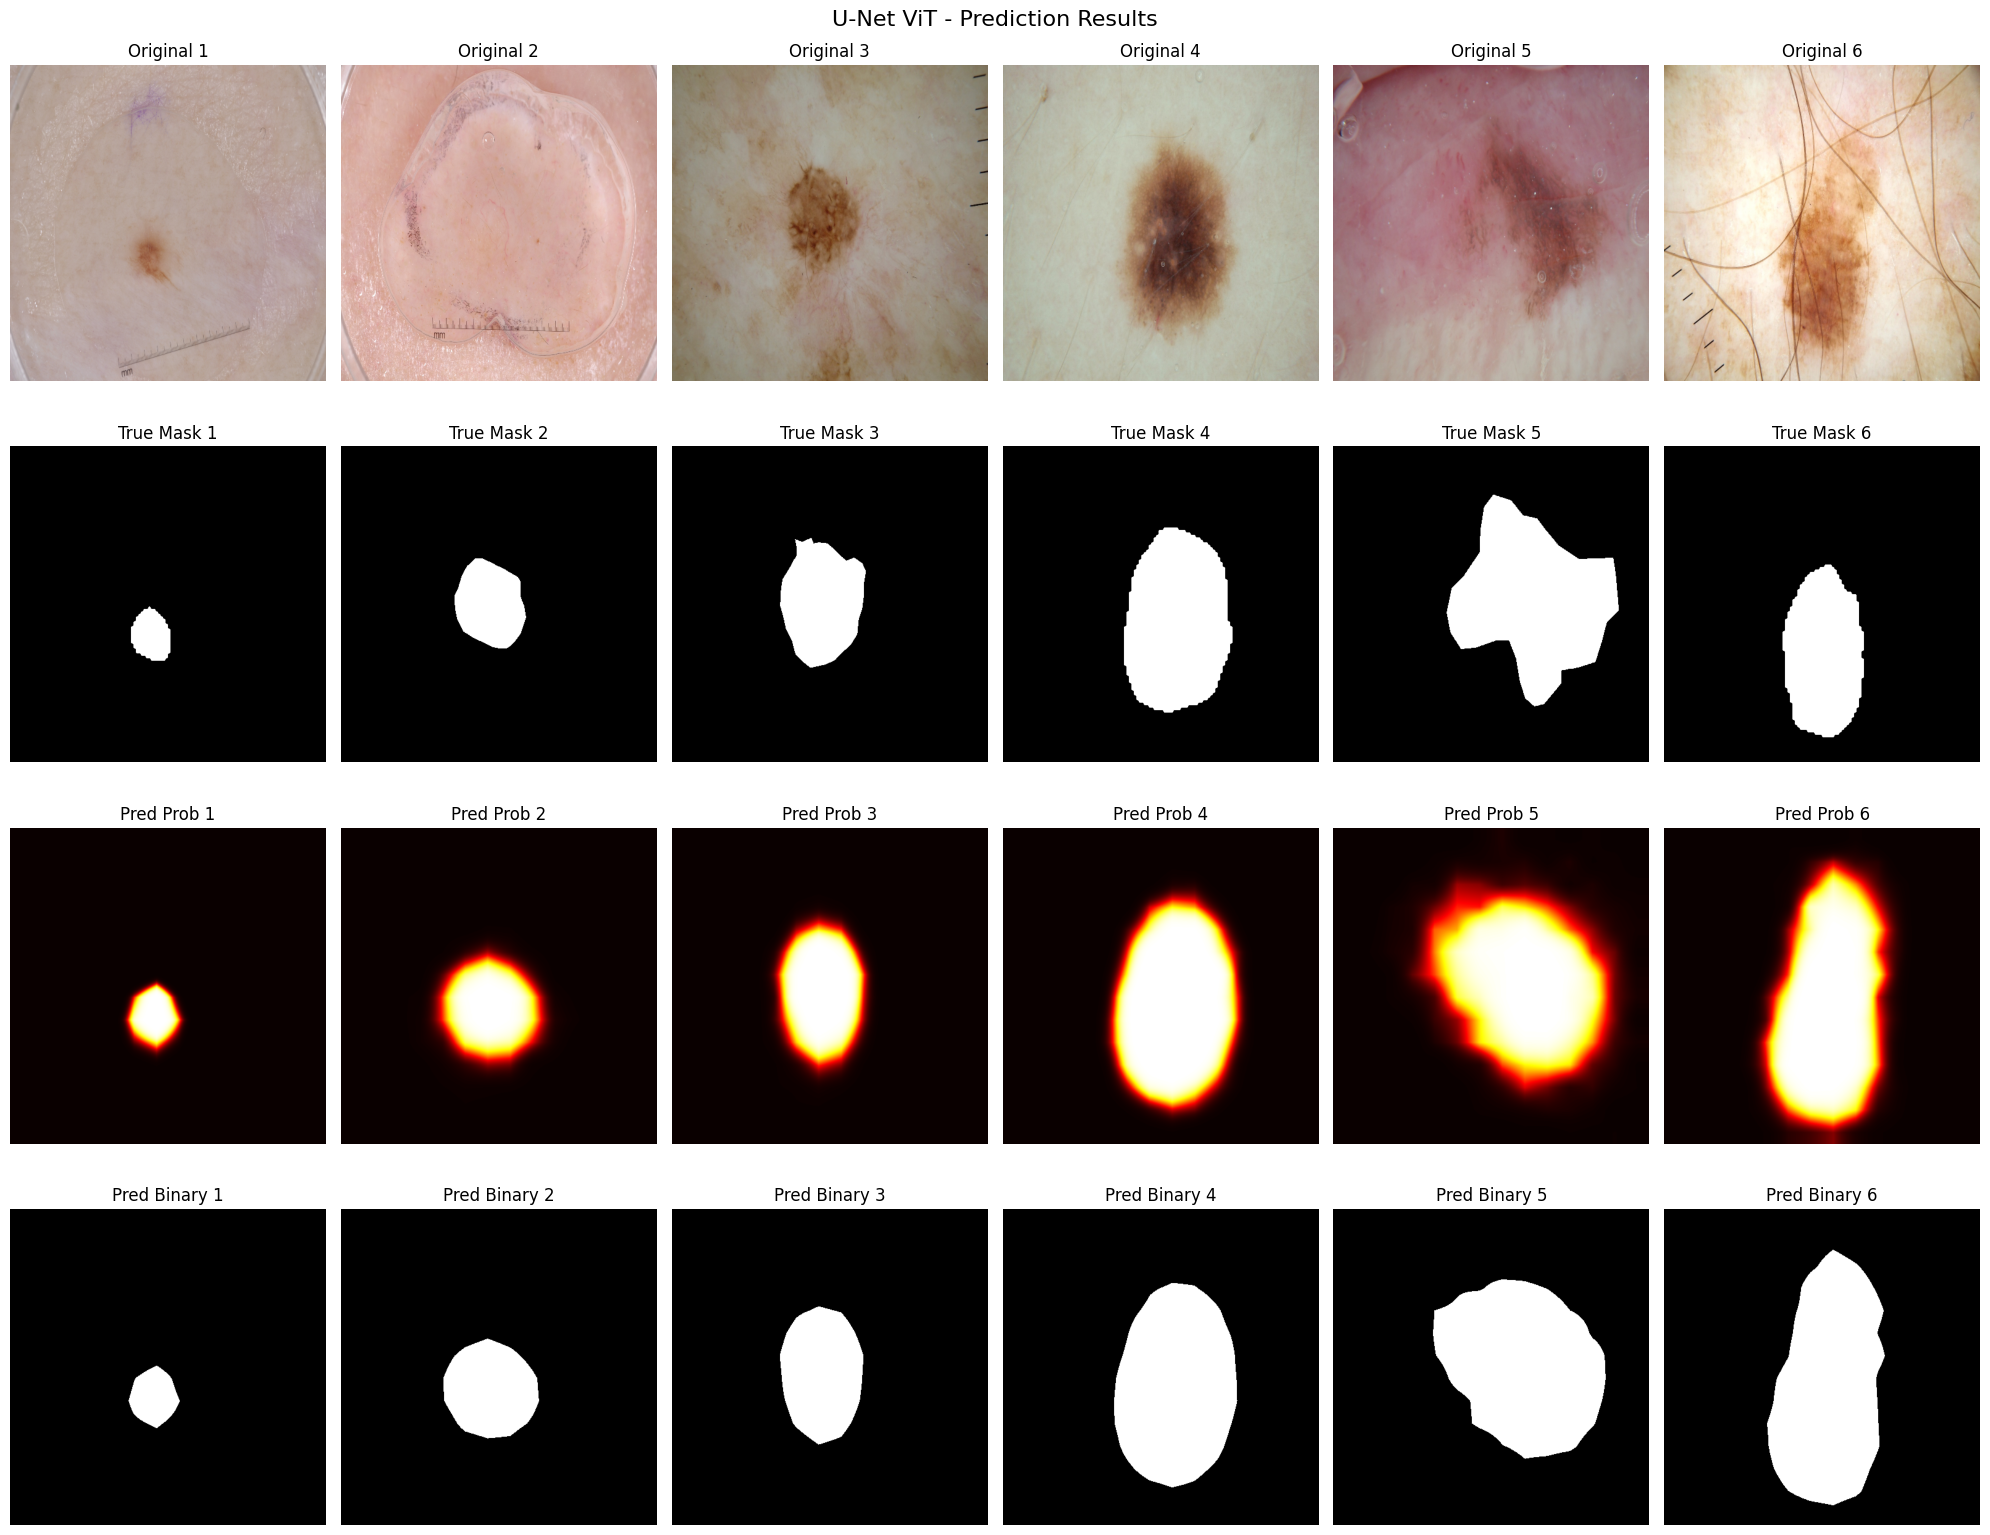

In [20]:
def evaluate_model_on_samples(model, val_loader, num_samples=6):
    """Evaluate model on sample images"""
    model.eval()
    
    # Get some samples
    samples = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples // val_loader.batch_size + 1:
                break
                
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            for j in range(min(images.shape[0], num_samples - len(samples))):
                # Denormalize image for visualization
                img = images[j].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                # Handle different tensor shapes
                if masks.dim() == 3:  # [batch, H, W]
                    true_mask = masks[j].cpu().numpy()
                else:  # [batch, 1, H, W]
                    true_mask = masks[j, 0].cpu().numpy()
                
                # Convert logits to probabilities first
                outputs_prob = torch.sigmoid(outputs)
                
                if outputs_prob.dim() == 3:  # [batch, H, W]
                    pred_mask = outputs_prob[j].cpu().numpy()
                    pred_binary = (outputs_prob[j] > 0.5).cpu().numpy().astype(np.uint8)
                else:  # [batch, 1, H, W]
                    pred_mask = outputs_prob[j, 0].cpu().numpy()
                    pred_binary = (outputs_prob[j, 0] > 0.5).cpu().numpy().astype(np.uint8)
                
                samples.append({
                    'image': img.permute(1, 2, 0).numpy(),
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'pred_binary': pred_binary
                })
                
                if len(samples) >= num_samples:
                    break
    
    # Visualize results
    fig, axes = plt.subplots(4, len(samples), figsize=(20, 16))
    
    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # True mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title(f'True Mask {i+1}')
        axes[1, i].axis('off')
        
        # Predicted mask (probability)
        axes[2, i].imshow(sample['pred_mask'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title(f'Pred Prob {i+1}')
        axes[2, i].axis('off')
        
        # Predicted mask (binary)
        axes[3, i].imshow(sample['pred_binary'], cmap='gray')
        axes[3, i].set_title(f'Pred Binary {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('U-Net ViT - Prediction Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Evaluate model on samples
print("🔍 Đánh giá model trên validation samples:")
evaluate_model_on_samples(model, val_loader, num_samples=6)

## 9. Final Results Summary

In [21]:
# Print final results
print("🎯 U-NET VIT TRAINING RESULTS")
print("=" * 50)
print(f"📊 Final Metrics (Last Epoch):")
print(f"   - Training Loss: {unet_vit_history['train_losses'][-1]:.4f}")
print(f"   - Validation Loss: {unet_vit_history['val_losses'][-1]:.4f}")
print(f"   - Training Dice: {unet_vit_history['train_dice'][-1]:.4f}")
print(f"   - Validation Dice: {unet_vit_history['val_dice'][-1]:.4f}")
print(f"   - Training Jaccard: {unet_vit_history['train_jaccard'][-1]:.4f}")
print(f"   - Validation Jaccard: {unet_vit_history['val_jaccard'][-1]:.4f}")

print(f"\n🏆 Best Metrics:")
best_val_dice_idx = np.argmax(unet_vit_history['val_dice'])
best_val_jaccard_idx = np.argmax(unet_vit_history['val_jaccard'])
print(f"   - Best Validation Dice: {max(unet_vit_history['val_dice']):.4f} (Epoch {best_val_dice_idx + 1})")
print(f"   - Best Validation Jaccard: {max(unet_vit_history['val_jaccard']):.4f} (Epoch {best_val_jaccard_idx + 1})")

print(f"\n💾 Saved Models:")
print(f"   - models/unet_vit_model_best.pth")
print(f"   - models/unet_vit_model_final.pth")

print(f"\n📈 Model Performance:")
final_dice = unet_vit_history['val_dice'][-1]
final_jaccard = unet_vit_history['val_jaccard'][-1]

if final_dice > 0.85:
    print(f"   ✅ Excellent performance! Dice > 0.85")
elif final_dice > 0.80:
    print(f"   ✅ Good performance! Dice > 0.80")
elif final_dice > 0.75:
    print(f"   ⚠️  Acceptable performance. Dice > 0.75")
else:
    print(f"   ❌ Performance needs improvement. Dice < 0.75")

print(f"\n🚀 Next Steps:")
print(f"   1. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet")
print(f"   2. Compare all models' performance")
print(f"   3. Create ensemble predictions")

print("\n✅ U-Net ViT training completed successfully!")

🎯 U-NET VIT TRAINING RESULTS
📊 Final Metrics (Last Epoch):
   - Training Loss: 0.0174
   - Validation Loss: 0.1623
   - Training Dice: 0.8626
   - Validation Dice: 0.8681
   - Training Jaccard: 0.7692
   - Validation Jaccard: 0.7748

🏆 Best Metrics:
   - Best Validation Dice: 0.8696 (Epoch 16)
   - Best Validation Jaccard: 0.7768 (Epoch 16)

💾 Saved Models:
   - models/unet_vit_model_best.pth
   - models/unet_vit_model_final.pth

📈 Model Performance:
   ✅ Excellent performance! Dice > 0.85

🚀 Next Steps:
   1. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet
   2. Compare all models' performance
   3. Create ensemble predictions

✅ U-Net ViT training completed successfully!
